<a href="https://colab.research.google.com/github/RecaiEfeDik/Planetary-Route-Planning/blob/main/ELE562.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Planetary Route Planning

# Hohmann Transfer Orbit

In [ ]:
# @title Hohmann Transfer Orbit:

def hohmann_transfer(r1, r2, M):
    a = (r1 + r2) / 2

    G = 6.67e-11

    v1 = np.sqrt(G * M / r1)
    v2 = np.sqrt(G * M / r2)

    v1_transfer = np.sqrt(G * M * (2/r1 - 1/a))
    v2_transfer = np.sqrt(G * M * (2/r2 - 1/a))

    delta_v1 = v1_transfer - v1
    delta_v2 = v2 - v2_transfer

    return delta_v1, delta_v2


In [ ]:
# @title Example usage
import numpy as np
r1 = 7.0e6
r2 = 4.2e7
M = 5.972e24

delta_v1, delta_v2 = hohmann_transfer(r1, r2, M)
print("DeltaV1:" + str(delta_v1) + " m/s")
print("DeltaV2:" + str(delta_v2) + " m/s")

DeltaV1:2333.2647749289554 m/s
DeltaV2:1433.4973007351698 m/s


# Lamberts Method:

In [ ]:
# @title Lamberts Method:
import numpy as np

def lamberts_problem_solver(r_initial: np.array, r_destination: np.array, flight_time: float, mu: float):

  r_initial_length = np.linalg.norm(r_initial)
  r_destination_length = np.linalg.norm(r_destination)

  chord_length = np.linalg.norm(r_destination - r_initial)

  semi_parameter = (r_initial_length + r_destination_length + chord_length)/2

  chi_0 = np.sqrt(mu) * flight_time / semi_parameter


  a, chi_last = universal_function_finder(chi_0, r_initial_length,
                                          r_destination_length, mu, flight_time,
                                          semi_parameter, chord_length)


  z = (1 / a) * chi_last**2

  f = 1 - (chi_last**2 * c(z) / r_initial_length)
  g = flight_time - (np.power(chi_last, 3) * c(z)) / r_initial_length

  f_dot = (np.sqrt(mu) / (r_initial_length * r_destination_length)) * (z * s(z) - 1)
  g_dot = 1 - (chi_last**2 * s(z) / r_destination_length**2)

  v1 = (1 / g) * (r_destination - f * r_initial)
  v2 = (1 / g) * (g_dot * r_destination - r_initial)

  return v1, v2 , a




def universal_function_finder(chi, r1_mag, r2_mag, mu, f_t, s_p, c_l):

  alpha = 1 / ((2 * s_p - r1_mag - r2_mag) / 2)

  for i in range(1000):
        a = (2 * s_p - r1_mag - r2_mag + (c_l / (chi**2 * alpha))) / 2
        alpha = 1 / a
        z = alpha * chi**2
        C = c(z)
        S = s(z)
        f = (chi**3 * S + np.sqrt(mu) * s_p * chi - np.sqrt(mu) * f_t)
        f_prime = (3 * chi**2 * S + np.sqrt(mu) * s_p * alpha * chi**2 * C)

        chi_new = chi - f / f_prime
        if abs(chi_new - chi) < 1e-6:
            chi = chi_new
            break

        chi = chi_new

  return a, chi


def s(z: float):
  if z > 0:
    return (np.sqrt(z) - np.sin(np.sqrt(z))) / np.sqrt(np.power(z, 3))
  elif z < 0:
    return (np.sinh(np.sqrt(-z)) - np.sqrt(-z)) / (np.sqrt(-z))**3
  elif z == 0:
    return 1 / 6

def c(z: float):

  if z > 0:
    return ((1 - np.cos(np.sqrt(z))) / z)
  elif z < 0:
    return (np.cosh(np.sqrt(-z)) - 1) / (-z)
  else:
    return 1 / 2


In [ ]:
# @title Graph Plotter-3D

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from mpl_toolkits.mplot3d import Axes3D

def plot_orbit(r1, r2, v2, a):

  # Define the gravitational parameter (mu = G * (M1 + M2))
  mu = 398600  # Gravitational parameter for Earth in km^3/s^2

  # Define the orbital parameters
  h = np.cross(r1, v1)  # Cross product of the initial and final positions
  E_x = (np.power(np.linalg.norm(v2), 2) / 2) - (mu / np.linalg.norm(r2))
  e = np.sqrt(1 + (2 * E_x * np.power(np.linalg.norm(h), 2) / np.power(mu, 2)))  # Eccentricity
  i = np.radians(45)   # Inclination in degrees converted to radians
  omega = np.radians(45)  # Argument of periapsis in degrees converted to radians
  Omega = np.radians(45)  # Longitude of the ascending node in degrees converted to radians

  # Time array for one complete orbit
  t = np.linspace(0, 2 * np.pi * np.sqrt(a**3 / mu), 1000)

  # Mean anomaly
  def mean_anomaly(t, a, mu):
      return np.sqrt(mu / a**3) * t

  M = mean_anomaly(t, a, mu)

  # Solve Kepler's equation E - e*sin(E) = M for E
  def kepler(E, M, e):
      return E - e * np.sin(E) - M

  E = np.array([fsolve(kepler, M_i, args=(M_i, e))[0] for M_i in M])

  # True anomaly
  theta = 2 * np.arctan(np.sqrt((1 + e) / (1 - e)) * np.tan(E / 2))

  # Radial distance
  r = a * (1 - e**2) / (1 + e * np.cos(theta))

  # Position in the orbital plane
  x_orb = r * np.cos(theta)
  y_orb = r * np.sin(theta)
  z_orb = np.zeros_like(x_orb)

  # Rotation matrices for inclination, argument of periapsis, and longitude of ascending node
  R_i = np.array([[1, 0, 0],
                  [0, np.cos(i), -np.sin(i)],
                  [0, np.sin(i), np.cos(i)]])

  R_omega = np.array([[np.cos(omega), -np.sin(omega), 0],
                      [np.sin(omega), np.cos(omega), 0],
                      [0, 0, 1]])

  R_Omega = np.array([[np.cos(Omega), -np.sin(Omega), 0],
                      [np.sin(Omega), np.cos(Omega), 0],
                      [0, 0, 1]])

  # Combine the rotation matrices
  R = R_Omega @ R_i @ R_omega

  # Apply the rotation to the orbital plane coordinates
  r_3d = np.vstack((x_orb, y_orb, z_orb))
  r_3d_rotated = R @ r_3d

  # Plot the 3D orbit
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection='3d')
  ax.plot(r_3d_rotated[0], r_3d_rotated[1], r_3d_rotated[2], label='Orbit')
  ax.set_xlabel('X (km)')
  ax.set_ylabel('Y (km)')
  ax.set_zlabel('Z (km)')
  ax.set_title('3D Orbital Trajectory')
  ax.legend()
  plt.show()



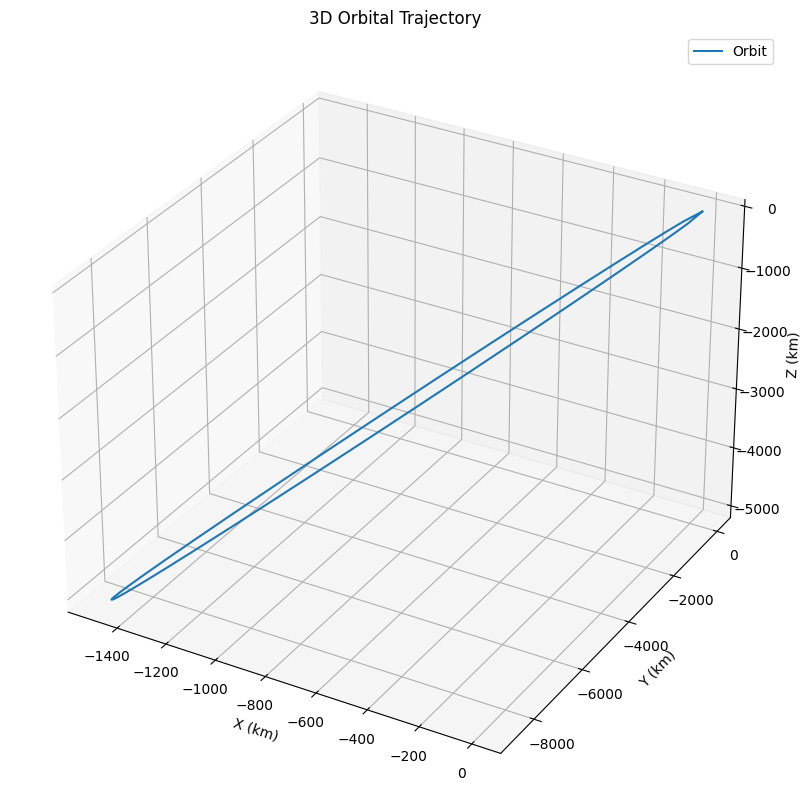

In [ ]:
# @title An Example
r1 = np.array([-2000, 1000, 6000])  # km
r2 = np.array([6000, -5000, 8000])  # km/s
delta_t = 76000  # seconds
mu = 398600  # km^3/s^2
v1, v2, a= lamberts_problem_solver(r1, r2, delta_t, mu)
plot_orbit(r1, r2, v2, a)

# DNN Application for Solving Lambert's Problem

In [ ]:
!pip install poliastro --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.8/910.8 kB 15.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from poliastro.bodies import Earth
from poliastro.iod import lambert
from astropy import units as u

num_samples = 10000

r1_vectors = np.random.uniform(-10000, 10000, (num_samples, 3)) * u.km
r2_vectors = np.random.uniform(-10000, 10000, (num_samples, 3)) * u.km
time_intervals = np.random.uniform(1, 10000, num_samples) * u.s

v1_vectors = []

for r1, r2, dt in zip(r1_vectors, r2_vectors, time_intervals):
    try:
        (v1, v2) = lambert(Earth.k, r1, r2, dt)
        v1_vectors.append(v1.value)
    except:
        v1_vectors.append([np.nan, np.nan, np.nan])

v1_vectors = np.array(v1_vectors)

data = pd.DataFrame({
    'r1_x': r1_vectors[:, 0].value,
    'r1_y': r1_vectors[:, 1].value,
    'r1_z': r1_vectors[:, 2].value,
    'r2_x': r2_vectors[:, 0].value,
    'r2_y': r2_vectors[:, 1].value,
    'r2_z': r2_vectors[:, 2].value,
    'dt': time_intervals.value,
    'v1_x': v1_vectors[:, 0],
    'v1_y': v1_vectors[:, 1],
    'v1_z': v1_vectors[:, 2]
})

data = data.dropna()

excel_path_proper = 'lambert_dataset_proper.xlsx'
data.to_excel(excel_path_proper, index=False)

lambert_data_proper = data

print("Dataset created and saved to lambert_dataset_proper.xlsx")





Dataset created and saved to lambert_dataset_proper.xlsx


In [ ]:
# @title DNN Data Exploring

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


dataset = pd.read_excel('lambert_dataset_proper.xlsx')

features = dataset.iloc[:,0:7]
labels = dataset.iloc[:,7:10]

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=42)

ct = ColumnTransformer([('scale', StandardScaler(), ['r1_x', 'r1_y', 'r1_z', 'r2_x', 'r2_y', 'r2_z', 'dt'])], remainder='passthrough')
features_train = ct.fit_transform(features_train)
features_test = ct.transform(features_test)


In [ ]:
# @title DNN Model

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import randint
from sklearn.metrics import make_scorer, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import randint

model = Sequential()

model.add(InputLayer(input_shape=(7,)))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(3, activation='softmax'))


opt = Adam(learning_rate = 0.0001)
model.compile(loss='mse',  metrics=['accuracy', 'mae'], optimizer=opt)

stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(features_train, labels_train, epochs=100, batch_size=20, verbose=0, validation_split=0.2, callbacks=[stop])

val_mse, val_accuracy, val_mae = model.evaluate(features_test, labels_test, verbose = 0)

print("Mse:", val_mse, "Acu:", val_accuracy, "Mae:", val_mae)



Epoch 82: early stopping
Mse: 1144.196533203125 Acu: 0.7833333611488342 Mae: 7.006068706512451
